In [1]:
!pip install keras --quiet

In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing import sequence

In [3]:
from google.colab import  drive
drive.mount('/drive')

Mounted at /drive


# Data

In [5]:
id_list = list(df['admissionid'].unique())
SPLIT_SIZE = 0.2
len(id_list)

2809

In [6]:
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
print("train is %d" % len(id_train))
# remaining 20% split in halves as test and validation 10% and 10%
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print("val and test are %d" %len(id_test))

train is 2247
val and test are 281


In [7]:
train = df[df.admissionid.isin(id_train)].sort_values(by=['admissionid'])
test = df[df.admissionid.isin(id_test)].sort_values(by=['admissionid'])
validation = df[df.admissionid.isin(id_valid)].sort_values(by=['admissionid'])

test = test.sort_values(by=['admissionid', 'time'], ignore_index = True)
train = train.sort_values(by=['admissionid', 'time'], ignore_index = True)
validation = validation.sort_values(by=['admissionid', 'time'], ignore_index = True)

In [8]:
col_x = ['admissionid', 'time','steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']
col_y = ['admissionid', 'time', "deceased"]

x_train = train[col_x]
y_train = train[col_y]
x_validation = validation[col_x]
y_validation = validation[col_y]
x_test = test[col_x]
y_test = test[col_y]

x_train.set_index(['admissionid','time'], append=True, inplace=True)
y_train.set_index(['admissionid','time'], append=True, inplace=True)
x_validation.set_index(['admissionid','time'], append=True, inplace=True)
y_validation.set_index(['admissionid','time'], append=True, inplace=True)
x_test.set_index(['admissionid','time'], append=True, inplace=True)
y_test.set_index(['admissionid','time'], append=True, inplace=True)

In [9]:
# max number of sequence length
maxlen = 90 # 720 hours max LOS divided by 8 hours timestep

# get a list of unique patient encounter IDs
teId = x_train.index.levels[1]
veId = x_validation.index.levels[1]
teeId = x_test.index.levels[1]

# pad every patient sequence with 0s to be the same length,
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations
X_train = [x_train.loc[(slice(None), patient), :].values for patient in teId]
y_train = [y_train.loc[(slice(None), patient), :].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [x_validation.loc[(slice(None), patient), :].values for patient in veId]
y_valid = [y_validation.loc[(slice(None), patient), :].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

X_test = [x_test.loc[(slice(None), patient), :].values for patient in teeId]
y_test = [y_test.loc[(slice(None), patient), :].values for patient in teeId]

X_test = sequence.pad_sequences(X_test, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

In [10]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))
print("X_test shape: %s | y_test shape: %s" % (str(X_test.shape), str(y_test.shape)))

X_train shape: (2247, 90, 22) | y_train shape: (2247, 90, 1)
X_valid shape: (281, 90, 22) | y_valid shape: (281, 90, 1)
X_test shape: (281, 90, 22) | y_test shape: (281, 90, 1)


ix = 1387


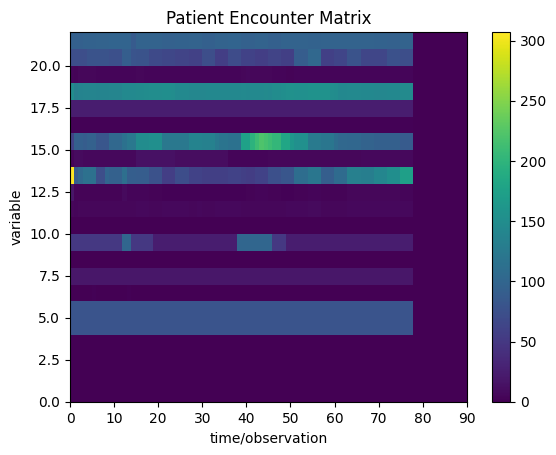

In [11]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,numencnt) #Try a few different index values between 0 and 4999
print('ix = {}'.format(ix))

# plot a matrix of observation values
plt.title("Patient Encounter Matrix")
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/observation")
plt.ylim(0,22)
plt.colorbar()
plt.show()

# Import model

In [12]:
model = tf.keras.models.load_model('/drive/MyDrive/Model')

In [13]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking

In [13]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 90, 22)]          0         
                                                                 
 input_masked (Masking)      (None, 90, 22)            0         
                                                                 
 lstm1 (LSTM)                (None, 90, 128)           77312     
                                                                 
 output (TimeDistributed)    (None, 90, 1)             129       
                                                                 
Total params: 77441 (302.50 KB)
Trainable params: 77441 (302.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
print(model.layers[2])

# Reliability curve

In [15]:
def reliability_curve(y_true, y_pred, num_bins=10):
    # Calculate the predicted probability for each data point
    prob_pred = np.clip(y_pred, 0, 1)  # Clip to ensure predicted probabilities are within [0, 1]

    # Create bins for predicted probabilities
    bins = np.linspace(0, 1, num_bins + 1)

    # Digitize the predicted probabilities into bins
    bin_indices = np.digitize(prob_pred, bins, right=True)

    # Initialize lists to store average predictions and empirical probabilities
    avg_pred = []
    empirical_prob = []

    # Calculate average predictions and empirical probabilities for each bin
    for i in range(1, num_bins + 1):
        mask = bin_indices == i
        if np.any(mask):
            bin_pred = np.mean(prob_pred[mask])
            bin_true = np.sum(y_true[mask]) / np.sum(mask)

            avg_pred.append(bin_pred)
            empirical_prob.append(bin_true)

    # Plot the reliability curve
    plt.plot(avg_pred, empirical_prob, marker='o', label='Reliability Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    # Set plot labels and legend
    plt.xlabel('Average Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Curve')
    plt.legend()

    # Show the plot
    plt.show()

In [126]:
# make predictions on the test set
y_pred = model.predict(X_test)
# predictions on validation set
y_pred_val = model.predict(X_valid)

9/9 [==============================] - 0s 37ms/step


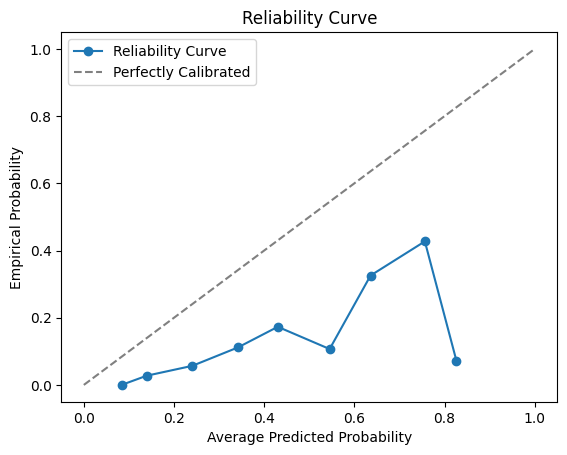

In [16]:
reliability_curve(y_test, y_pred, num_bins=10)

## ML insights package

In [17]:
!pip install ml_insights


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for splinecalib: filename=splinecalib-0.0.7-cp310-cp310-linux_x86_64.whl size=156848 sha256=8e4556b2c211d053a9a32ed367b3be43f94fb64f7485c6b812499e1921159e36
  Stored in directory: /root/.cache/pip/wheels/50/95/b1/480a780100c1a0edefa1c989a3814646cb3760c46d4ad2a181
Successfully built splinecalib


In [37]:
import ml_insights as mli

In [18]:
from ml_insights import plot_reliability_diagram

In [19]:
def create_reliability_curve(y_true, y_pred, custom_bins=None):
    if custom_bins is not None:
        bins = custom_bins
    else:
        bins = np.linspace(0, 1, 11)  # Default: 10 bins

    plot_reliability_diagram(y_true, y_pred, bins=bins, marker='o')

    plt.xlabel('Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Curve with Confidence Intervals')

    plt.show()

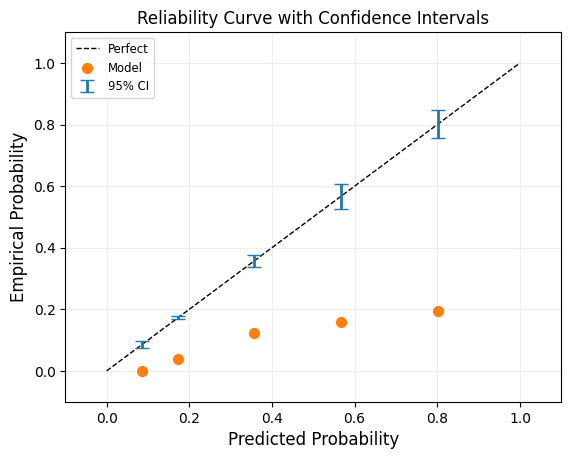

In [20]:
custom_bins = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

create_reliability_curve(y_test, y_pred, custom_bins=custom_bins)

{'pred_probs': array([0.08565038, 0.12273916, 0.17298998, 0.22213167, 0.2689015 ,
        0.32331604, 0.36668971, 0.42327634, 0.47701892, 0.52620739,
        0.5644601 , 0.62504476, 0.67505354, 0.72293895, 0.77206135,
        0.82637221]),
 'emp_probs': array([0.00096494, 0.01922849, 0.04385542, 0.05014142, 0.0670347 ,
        0.12421242, 0.09394314, 0.14130434, 0.3888889 , 0.125     ,
        0.0882353 , 0.20792079, 0.75      , 0.90909094, 0.2       ,
        0.07179487]),
 'bin_counts': array([3109., 8425., 4150., 3889., 2536., 1111.,  809.,  368.,   54.,
         208.,  204.,  101.,   28.,   33.,   70.,  195.])}

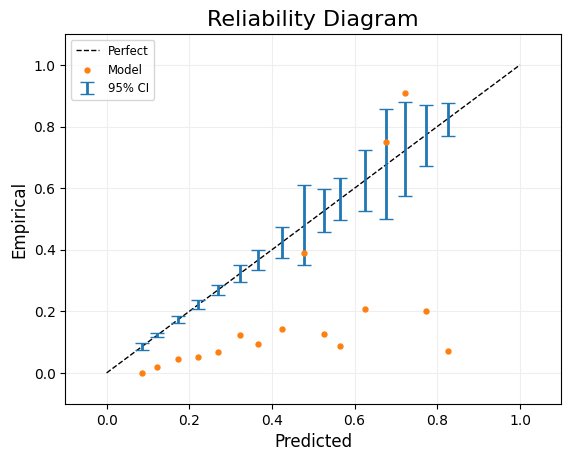

In [142]:
mli.plot_reliability_diagram(y_test, y_pred, marker='.')

#Calibration graph == same as reliability graph

In [21]:
# Reshape y_pred and y_test to 2D arrays
y_test_2d = y_test.reshape(y_test.shape[0], -1)
y_pred_2d = y_pred.reshape(y_pred.shape[0], -1)

In [22]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test.ravel(), y_pred_2d.ravel(), n_bins=10, strategy='uniform')


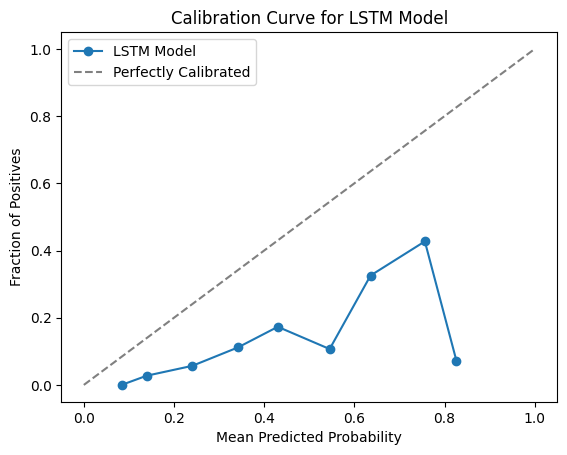

In [23]:
# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='LSTM Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for LSTM Model')
plt.legend()
plt.show()

# Platt scaling

In [34]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [66]:
class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, epochs=10, batch_size=32)

    def predict_proba(self, X):
        return self.keras_model.predict(X)

In [155]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [213]:
# Platt scaling with Keras model
wrapper_model = KerasClassifierWrapper(model)
wrapper_model.fit(X_train2, y_train2)

Epoch 1/10
57/57 [==============================] - 16s 219ms/step - loss: 0.5317
Epoch 2/10
57/57 [==============================] - 11s 187ms/step - loss: 0.5231
Epoch 3/10
57/57 [==============================] - 13s 220ms/step - loss: 0.5172
Epoch 4/10
57/57 [==============================] - 13s 224ms/step - loss: 0.5218
Epoch 5/10
57/57 [==============================] - 13s 222ms/step - loss: 0.5229
Epoch 6/10
57/57 [==============================] - 12s 218ms/step - loss: 0.5250
Epoch 7/10
57/57 [==============================] - 11s 190ms/step - loss: 0.5213
Epoch 8/10
57/57 [==============================] - 13s 222ms/step - loss: 0.5112
Epoch 9/10
57/57 [==============================] - 13s 223ms/step - loss: 0.5229
Epoch 10/10
57/57 [==============================] - 13s 223ms/step - loss: 0.5185


In [214]:
y_calibrated_pred = wrapper_model.predict_proba(X_test)[:, 1]

9/9 [==============================] - 0s 49ms/step


In [215]:
y_valid_1d = y_valid[:, 0, 0]
#y_valid_1d = y_valid_2d.reshape(y_valid_2d.shape[1], -1)
prob_true2, prob_pred2 = calibration_curve(y_valid_1d, y_calibrated_pred, n_bins=10, strategy='uniform')

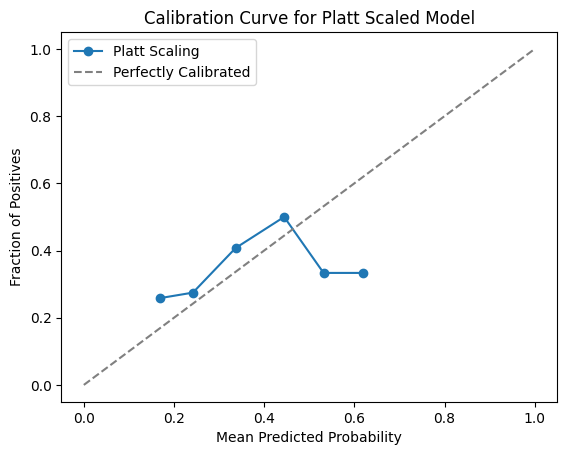

In [216]:
plt.plot(prob_pred2, prob_true2, marker='o', label='Platt Scaling')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Platt Scaled Model')
plt.legend()
plt.show()

## Isotonic Regression

In [127]:
y_pred_1d = y_pred[:, 0, 0]
y_test_1d = y_test[:, 0, 0]
y_pred_val1d = y_pred_val[:, 0, 0]

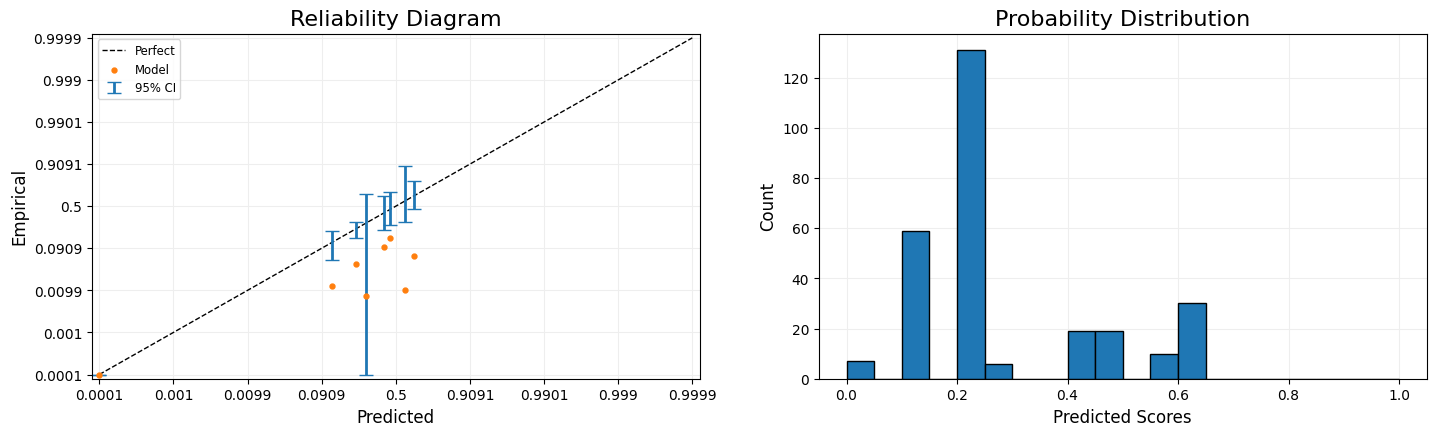

In [129]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit(y_pred_val1d, y_valid_1d)
testset_iso_probs = iso.predict(y_pred_1d)
plt.figure(figsize=(15,5))
mli.plot_reliability_diagram(y_test, testset_iso_probs,show_histogram=True,scaling='logit');

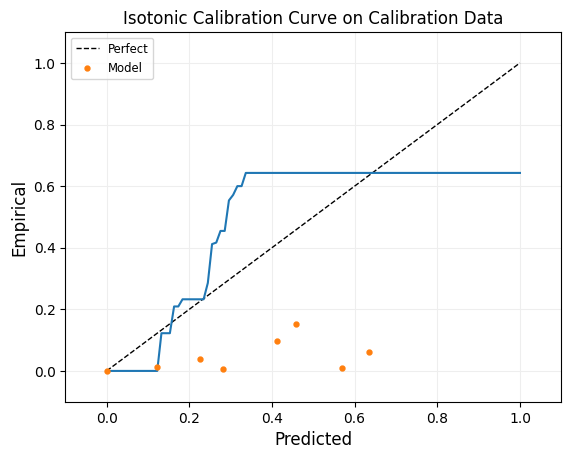

In [130]:
mli.plot_reliability_diagram(y_test, testset_iso_probs, error_bars=False);
tvec = np.linspace(0, 1, 99)
plt.plot(tvec, iso.predict(tvec));
plt.title('Isotonic Calibration Curve on Calibration Data');

In [131]:
from sklearn.metrics import roc_auc_score

In [134]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_test_1d, testset_iso_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1d, y_pred_1d)))
print('Isotonic calibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, testset_iso_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, y_pred_1d)))

Isotonic calibrated log_loss = 0.5491458122994831
Uncalibrated log_loss = 0.5437583359402302
Isotonic calibrated ROC_AUC = 0.6415436149849604
Uncalibrated ROC_AUC = 0.6505332239540608


# Spline calibration

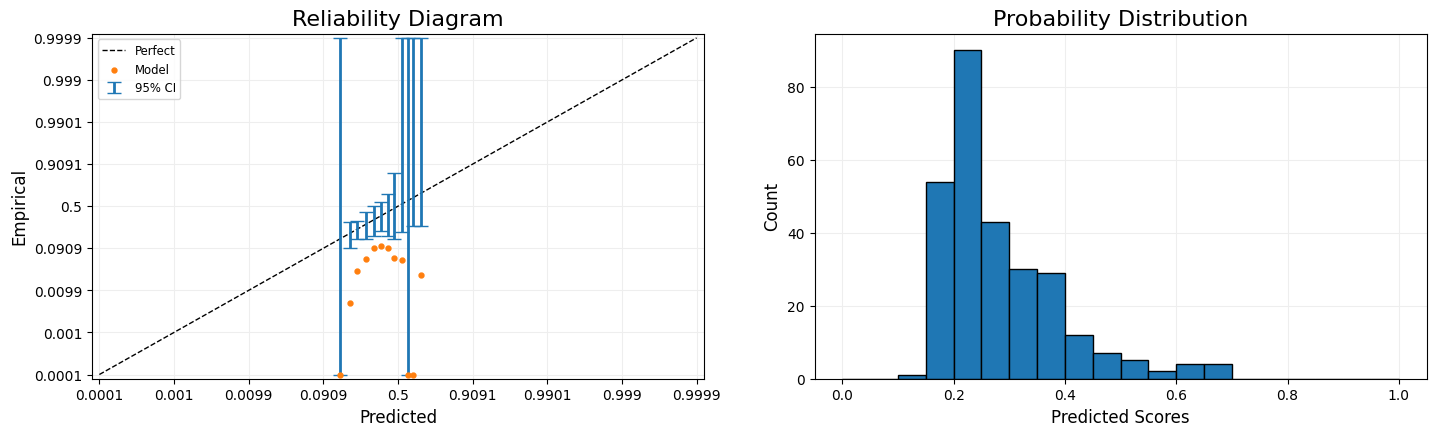

In [138]:
splinecalib = mli.SplineCalib()
splinecalib.fit(y_pred_val1d, y_valid_1d)
testset_splinecalib_probs = splinecalib.predict(y_pred_1d)
plt.figure(figsize=(15,5))
mli.plot_reliability_diagram(y_test, testset_splinecalib_probs,show_histogram=True,scaling='logit');

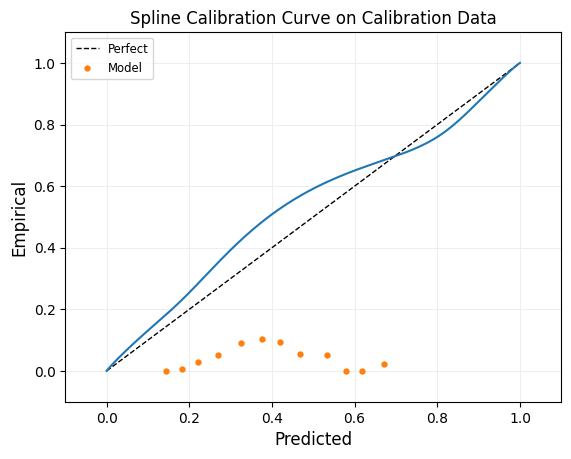

In [139]:
mli.plot_reliability_diagram(y_test, testset_splinecalib_probs,error_bars=False);
tvec = np.linspace(0, 1, 999)
plt.plot(tvec, splinecalib.predict(tvec));
plt.title('Spline Calibration Curve on Calibration Data');

In [141]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_test_1d, testset_splinecalib_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1d, y_pred_1d)))
print('Spline calibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, testset_splinecalib_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, y_pred_1d)))

Spline calibrated log_loss = 0.5435681759969628
Uncalibrated log_loss = 0.5437583359402302
Spline calibrated ROC_AUC = 0.6505332239540608
Uncalibrated ROC_AUC = 0.6505332239540608


# All models together

In [150]:
! pip install betacal

In [151]:
from betacal import BetaCalibration

In [204]:
# Fit three-parameter beta calibration
bc = BetaCalibration(parameters="abm")
bc.fit(y_pred_1d, y_test_1d)

# Fit Isotonic Regression
iso = IsotonicRegression()
iso.fit(y_pred_1d, y_test_1d)

# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999)
lr.fit(y_pred_1d.reshape(-1,1), y_test_1d)

LogisticRegression(C=99999999999)

In [189]:
print(tvec.shape)

(90,)


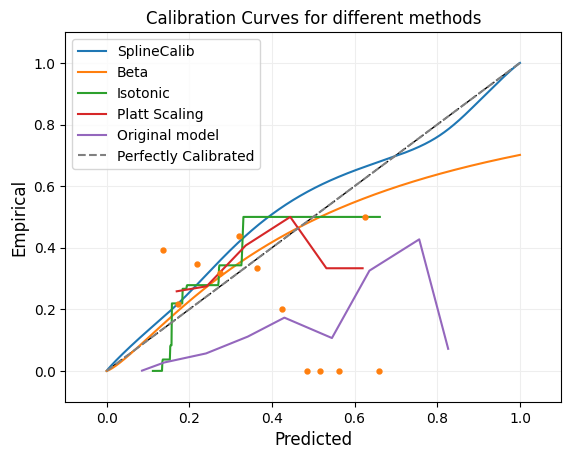

In [218]:
tvec = np.linspace(0,1,1001)
bc_probs = bc.predict(tvec)
iso_probs = iso.predict(tvec)
platt_probs = lr.predict(tvec.reshape(-1,1))
splinecalib_probs = splinecalib.calibrate(tvec)
#calib3.show_calibration_curve()
mli.plot_reliability_diagram(y_valid_1d, y_pred_1d, error_bars=False);
plt.plot(tvec, splinecalib_probs, label='SplineCalib')
plt.plot(tvec, bc_probs, label='Beta')
plt.plot(tvec, iso_probs, label='Isotonic')
plt.plot(prob_pred2, prob_true2, label='Platt Scaling')
plt.plot(prob_pred, prob_true, label='Original model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
#plt.plot(tvec, platt_probs, label='Platt')
plt.legend()
plt.title('Calibration Curves for different methods');

In [208]:
preds_test_bc = bc.predict(y_pred_1d)
preds_test_iso = iso.predict(y_pred_1d)
preds_test_platt = lr.predict_proba(y_pred_1d.reshape(-1,1))[:,1]
preds_test_splinecalib = splinecalib.calibrate(y_pred_1d)

In [210]:
bc_loss = log_loss(y_test_1d, preds_test_bc)
iso_loss = log_loss(y_test_1d, preds_test_iso)
platt_loss = log_loss(y_test_1d, preds_test_platt)
splinecalib_loss = log_loss(y_test_1d, preds_test_splinecalib)

In [ ]:
print('Uncalibrated log_loss = {}'.format(log_loss(y_test_1d, y_pred_1d)))
print('Spline calibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, testset_splinecalib_probs)))
print('Uncalibrated ROC_AUC = {}'.format(roc_auc_score(y_test_1d, y_pred_1d)))

In [221]:
print('Uncalibrated loss   = {:.5f}'.format(round(log_loss(y_test_1d, y_pred_1d), 5)))
print('Platt loss          = {}'.format(np.round(platt_loss,5)))
print('Beta Calib loss     = {}'.format(np.round(bc_loss,5)))
print('Isotonic loss       = {}'.format(np.round(iso_loss,5)))
print('SplineCalib loss    = {}'.format(np.round(splinecalib_loss,5)))
print('Uncalibrated ROC_AUC= {}'.format(round(roc_auc_score(y_test_1d, y_pred_1d),5)))
print('Platt ROC_AUC       = {}'.format(round(roc_auc_score(y_test_1d, preds_test_platt),5)))
print('Beta Calib ROC_AUC  = {}'.format(round(roc_auc_score(y_test_1d, preds_test_bc),5)))
print('Isotonic ROC_AUC    = {}'.format(round(roc_auc_score(y_test_1d, preds_test_iso),5)))
print('SplineCalib ROC_AUC = {}'.format(round(roc_auc_score(y_test_1d, preds_test_splinecalib),5)))

Uncalibrated loss   = 0.54376
Platt loss          = 0.54532
Beta Calib loss     = 0.53826
Isotonic loss       = 0.50555
SplineCalib loss    = 0.54357
Uncalibrated ROC_AUC= 0.65053
Platt ROC_AUC       = 0.65053
Beta Calib ROC_AUC  = 0.65053
Isotonic ROC_AUC    = 0.68123
SplineCalib ROC_AUC = 0.65053
